- CoolProp
- http://www.coolprop.org/coolprop/REFPROP.html
- http://www.coolprop.org/coolprop/HighLevelAPI.html#calling-refprop
- http://www.coolprop.org/coolprop/LowLevelAPI.html#low-level-interface-using-refprop
- http://www.coolprop.org/coolprop/LowLevelAPI.html#generating-input-pairs
- SciPy
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.savemat.html
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

Relevant tickets:
- HEMAXX https://github.com/usnistgov/REFPROP-wrappers/issues/163
- DQ RefProp https://github.com/usnistgov/REFPROP-issues/issues/189
- DQ CoolProp https://github.com/CoolProp/CoolProp/issues/1845
- sat crit https://github.com/usnistgov/REFPROP-wrappers/issues/152 
- melt line https://github.com/CoolProp/CoolProp/issues/1550
- p_melt https://github.com/CoolProp/CoolProp/issues/1865

In [1]:
# all imports happen here
import numpy as np
from numpy.linalg import solve
from numpy.linalg import lstsq
from numpy import log
from scipy.interpolate import griddata
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import CoolProp as CP
from CoolProp.CoolProp import PropsSI

# Check: CoolProp version
print(CP.__version__)
print(CP.__gitrevision__)

# Constants
eps = 1e-3
kilo = 1e3
Mega = 1e6
golden = (1 + 5 ** 0.5) / 2
width = 12.5

6.3.0
ba41b1434002b1fce6e596386861bca2a890fb6f


In [2]:
# Set FluidName
FluidName = 'Propane'
BackEnd = 'REFPROP'
myFluid = BackEnd + '::' + FluidName 


# Constants, triple and critical data
R = PropsSI('GAS_CONSTANT',myFluid)
MM = PropsSI('MOLAR_MASS',myFluid)
Rs = R/MM

T_crt = PropsSI('T_CRITICAL',myFluid)
T_trp = PropsSI('T_TRIPLE',myFluid)
T_max = PropsSI('T_MAX',myFluid)

p_crt = PropsSI('P_CRITICAL',myFluid)
p_trp = PropsSI('P_TRIPLE',myFluid)
p_max = PropsSI('P_MAX',myFluid)

d_crt = PropsSI('RHOMASS_CRITICAL',myFluid)
d_trp_vap = PropsSI('D','T',T_trp,'Q',1,myFluid)
d_trp_liq = PropsSI('D','T',T_trp,'Q',0,myFluid)
v_crt = 1/d_crt
v_trp_vap = 1/d_trp_vap
v_trp_liq = 1/d_trp_liq

h_crt = PropsSI('H','T',T_crt,'D',d_crt,myFluid)
s_crt = PropsSI('S','T',T_crt,'D',d_crt,myFluid)

print(f"MM = {MM} kg/mol")
print(f"R  = {R} J/(mol.K)")
print(f"Rs = {Rs} J/(kg.K)")
print()
print(f"T_trp = {T_trp: 6.2f} K")
print(f"T_crt = {T_crt: 6.2f} K ({T_crt-273.15:.2f} C)")
print(f"T_max = {T_max:.2f} K")
print()
print("p_trp = {:.2E} Pa".format(p_trp))
print("p_crt = {:.2E} Pa".format(p_crt))
print("p_max = {:.2E} Pa".format(p_max))
print()
print("d_trp_vap = {:.2f} kg/m3".format(d_trp_vap))
print("d_trp_liq = {:.2f} kg/m3".format(d_trp_liq))

MM = 0.044095619999999995 kg/mol
R  = 8.3144598 J/(mol.K)
Rs = 188.55523065556173 J/(kg.K)

T_trp =  85.53 K
T_crt =  369.89 K (96.74 C)
T_max = 650.00 K

p_trp = 1.72E-04 Pa
p_crt = 4.25E+06 Pa
p_max = 1.00E+09 Pa

d_trp_vap = 0.00 kg/m3
d_trp_liq = 733.13 kg/m3


In [3]:
# Saturation properties
nPoints = 1000
T_sat = np.linspace(T_trp, T_crt, num=nPoints)

# two AbstractState instances
vapState = CP.AbstractState(BackEnd, FluidName)
liqState = CP.AbstractState(BackEnd, FluidName)

# empty arrays, for all properties in the loop
p_sat = np.empty(nPoints)
p_mlt = np.empty(nPoints)
d_vap = np.empty(nPoints)
d_liq = np.empty(nPoints)
h_vap = np.empty(nPoints)
h_liq = np.empty(nPoints)
s_vap = np.empty(nPoints)
s_liq = np.empty(nPoints)

# loop to get values
for idx in range(0,nPoints):
    # update states
    vapState.update(CP.QT_INPUTS, 1, T_sat[idx]) 
    liqState.update(CP.QT_INPUTS, 0, T_sat[idx])  
    
    # store values
    p_sat[idx] = liqState.p()
    p_mlt[idx] = liqState.melting_line(CP.iP, CP.iT, T_sat[idx])
    d_vap[idx] = vapState.rhomass()
    d_liq[idx] = liqState.rhomass()
    h_vap[idx] = vapState.hmass()
    h_liq[idx] = liqState.hmass()
    s_vap[idx] = vapState.smass()
    s_liq[idx] = liqState.smass()

# other calculated values
v_vap = 1/d_vap
v_liq = 1/d_liq

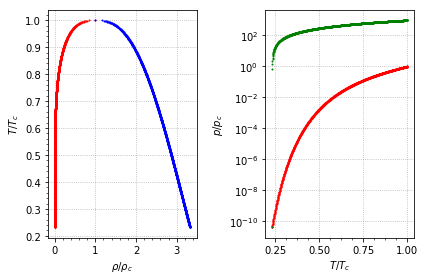

In [4]:
# subplot rows, cols, id
plt.subplot(1,2,1)
plt.plot(d_vap/d_crt, T_sat/T_crt, color='r', linestyle='none', marker='.', markersize=2)
plt.plot(d_liq/d_crt, T_sat/T_crt, color='b', linestyle='none', marker='.', markersize=2)
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel(r'$T / T_c$')

plt.subplot(1,2,2)
plt.plot(T_sat/T_crt, p_sat/p_crt, color='r', linestyle='none', marker='.', markersize=2)
plt.plot(T_sat/T_crt, p_mlt/p_crt,color='g', linestyle='none', marker='.', markersize=2)
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$T / T_c$')
plt.ylabel(r'$p / p_c$')
plt.yscale('log')

plt.tight_layout()
plt.savefig('SBTL_sat.pdf')
plt.show()

In [5]:
#pT plane
nPoints = 20

# two AbstractState instances
pT_State = CP.AbstractState(BackEnd, FluidName)

# empty arrays, for all properties in the loop
nPoints2 = nPoints*nPoints
d = np.empty(nPoints2)
T = np.empty(nPoints2)
p = np.empty(nPoints2)
h = np.empty(nPoints2)
s = np.empty(nPoints2)
ddph = np.empty(nPoints2)
ddhp = np.empty(nPoints2)
dTph = np.empty(nPoints2)
dThp = np.empty(nPoints2)

# loop to get values
idx=0
T_in = np.linspace(T_trp, 1.5*T_max, num=nPoints)
for Ti in range(0,nPoints):
    try:
        p_in = np.linspace(p_trp, min(p_max, pT_State.melting_line(CP.iP, CP.iT, T_in[Ti])) , num=nPoints) 
    except:
        p_in = np.linspace(p_trp, p_max , num=nPoints)         
    
    for pi in range(0,nPoints):
        # update state
        pT_State.update(CP.PT_INPUTS, p_in[pi], T_in[Ti])

        # store values
        d[idx] = pT_State.rhomass()
        T[idx] = pT_State.T()
        p[idx] = pT_State.p()
        h[idx] = pT_State.hmass()
        s[idx] = pT_State.smass()
        ddph[idx] = pT_State.first_partial_deriv(CP.iDmass, CP.iP, CP.iHmass)
        ddhp[idx] = pT_State.first_partial_deriv(CP.iDmass, CP.iHmass, CP.iP)
        dTph[idx] = pT_State.first_partial_deriv(CP.iT, CP.iP, CP.iHmass)
        dThp[idx] = pT_State.first_partial_deriv(CP.iT, CP.iHmass, CP.iP)
        idx += 1

# other calculated values
# v = 1/d

h min: -196643.0763696834, h max: 3692090.955352008
p min: 0.00017204592906531604, p max: 1000000000.0


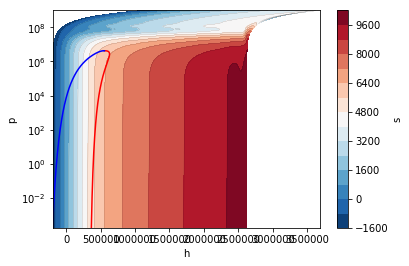

In [6]:
# grid transform
Xname = "h"
Yname = "p"
Zname = "s"

# assign data to x,y,z
x = h
y = p
z = s

# interpolate data to regular grid
print(f"{Xname} min: {x.min()}, {Xname} max: {x.max()}")
print(f"{Yname} min: {y.min()}, {Yname} max: {y.max()}")
xi = np.linspace(x.min(), x.max(), 400)
yi = np.linspace(y.min(), y.max(), 400)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic', rescale=True)

# plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel(Xname)
ax1.set_ylabel(Yname)
ax1.set_yscale("log") 
# lines
ax1.contour(xi, yi, zi, levels=16, linewidths=0.1, colors='k')
# filling
cont1 = ax1.contourf(xi, yi, zi, levels=16, cmap="RdBu_r")
# colorbar
cbar = fig.colorbar(cont1, ax=ax1)
cbar.set_label(Zname)
# sat line
plt.plot(h_vap, p_sat, color='r', linestyle='solid')
plt.plot(h_liq, p_sat, color='b', linestyle='solid')
# save fig
plt.savefig(Zname + '.pdf')
plt.show()

In [7]:
print(PropsSI('PIP','T',0.8*T_crt,'D',d_crt,myFluid))
print(PropsSI('HMASS','T',1.5*T_max,'D',d_crt,myFluid))

-24.755420595417373
2572151.189782727
